# Generalized Linear Models

In [1]:
# The easiest way to get recipes is to install all of tidymodels:
# install.packages("tidymodels")
options(encoding = 'UTF-8')
#Loading all the necessary packages
if (!require("caret")) install.packages("caret")
if (!require("recipes")) install.packages("recipes")
if (!require("visreg")) install.packages("visreg")
if (!require("MASS")) install.packages("MASS")
if (!require("glmnet")) install.packages("glmnet")
if (!require("jtools")) install.packages("jtools")
if (!require("scales")) install.packages("scales")
if (!require("forcats")) install.packages("forcats")
if (!require("stringr")) install.packages("stringr")
if (!require("poissonreg")) install.packages("poissonreg")



require("caret")
require("recipes")
require("visreg")
require("MASS")
require("glmnet")
require("jtools")
require("scales")
require("forcats")
require("stringr")
require("arrow")
require("forcats")
require("doParallel")
require("yardstick")
require("parsnip")
require("workflows")
require("poissonreg")
require("rsample")
require("tune")
require("yardstick")

options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 150);

Le chargement a nécessité le package : caret

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : lattice

Le chargement a nécessité le package : recipes

Le chargement a nécessité le package : dplyr


Attachement du package : 'dplyr'


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union



Attachement du package : 'recipes'


L'objet suivant est masqué depuis 'package:stats':

    step


Le chargement a nécessité le package : visreg

Le chargement a nécessité le package : MASS


Attachement du package : 'MASS'


L'objet suivant est masqué depuis 'package:dplyr':

    select


Le chargement a nécessité le package : glmnet

Le chargement a nécessité le package : Matrix

Loaded glmnet 4.1-3

Le chargement a nécessité le package : jtools

Le chargement a nécessité le package : scales

Le chargement a nécessité le package : forcats

Le 

We can also load the data (same as in the previous sessions).

In [3]:
dataset = read_parquet(file = "../data/dataset.parquet")

## Data Preparation

For GLMs, we will need to prepare the data that we feed to the model. Indeed, we will have to provide the list of variables we wish to use and also supply the interactions terms. On top of that, we will *probably* need to bin some continuous variables into categorical ones. Let us re-take a look at some of the variables in the dataset.

An important preliminary step is always data preparation. In our simple dataset, we only have 10 variables. As a reminder, we have the following variables.


In [4]:
str(dataset)

'data.frame':	410864 obs. of  10 variables:
 $ PolicyID : Factor w/ 413169 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ ClaimNb  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Exposure : num  0.09 0.84 0.52 0.45 0.15 0.75 0.81 0.05 0.76 0.34 ...
 $ Power    : Factor w/ 12 levels "d","e","f","g",..: 4 4 3 3 4 4 1 1 1 6 ...
 $ CarAge   : int  0 0 2 2 0 0 1 0 9 0 ...
 $ DriverAge: int  46 46 38 38 41 41 27 27 23 44 ...
 $ Brand    : Factor w/ 7 levels "Fiat","Japanese (except Nissan) or Korean",..: 2 2 2 2 2 2 2 2 1 2 ...
 $ Gas      : Factor w/ 2 levels "Diesel","Regular": 1 1 2 2 1 1 2 2 2 2 ...
 $ Region   : Factor w/ 10 levels "Aquitaine","Basse-Normandie",..: 1 1 8 8 9 9 1 1 8 6 ...
 $ Density  : int  76 76 3003 3003 60 60 695 695 7887 27000 ...


As we see, some variables are considered as integers (int) and others are considered as factors. For factor variable, an important feature is the **reference level**. R automatically assigns the **first category/value** encountered as reference level. This can often be suboptimal, and it is preferable to have as reference level the category with the most observation (or largest exposure).

### Brand

We can see the different levels of a factor variable with the levels function. The first level is the **reference level**.

In [5]:
levels(dataset$Brand)

[1] "Fiat"                               "Japanese (except Nissan) or Korean"
[3] "Mercedes, Chrysler or BMW"          "Opel, General Motors or Ford"      
[5] "other"                              "Renault, Nissan or Citroen"        
[7] "Volkswagen, Audi, Skoda or Seat"

Using the function *fct_count* from package *forcats* we can easily compute the number of rows for each level of the factor variable.

In [6]:
dataset$Brand %>% fct_count(sort=TRUE, prop=TRUE)

f,n,p
<fct>,<int>,<dbl>
"Renault, Nissan or Citroen",216684,0.52738619
Japanese (except Nissan) or Korean,79031,0.19235319
"Opel, General Motors or Ford",37287,0.09075266
"Volkswagen, Audi, Skoda or Seat",32384,0.07881927
"Mercedes, Chrysler or BMW",19087,0.04645576
Fiat,16653,0.04053166
other,9738,0.02370127


*Renault, Nissan or Citroen* appears to be the most populated level of variable ‘Brand’. This is why we will set this level as reference level, using the function **relevel**, or we can directly use the relevant function from the forcats package that will determine the most populated level and set that level as the reference level.

In [7]:
# dataset$Brand = relevel(x = dataset$Brand, ref= "Renault, Nissan or Citroen")
# Easier with forcats

dataset$Brand = dataset$Brand %>% fct_infreq()
levels(dataset$Brand)

[1] "Renault, Nissan or Citroen"         "Japanese (except Nissan) or Korean"
[3] "Opel, General Motors or Ford"       "Volkswagen, Audi, Skoda or Seat"   
[5] "Mercedes, Chrysler or BMW"          "Fiat"                              
[7] "other"

### Gas

In [8]:
dataset$Gas %>% fct_count(sort=TRUE, prop=TRUE)

f,n,p
<fct>,<int>,<dbl>
Regular,205565,0.5003237
Diesel,205299,0.4996763


We will set Regular as reference level.

In [9]:
dataset$Gas = dataset$Gas %>% fct_infreq()
levels(dataset$Gas)

[1] "Regular" "Diesel"

### Region

In [10]:
dataset$Region %>% fct_count(sort=TRUE, prop=TRUE)

f,n,p
<fct>,<int>,<dbl>
Centre,159426,0.38802621
Ile-de-France,69576,0.16934071
Bretagne,41986,0.10218953
Pays-de-la-Loire,38541,0.09380476
Aquitaine,31211,0.07596431
Nord-Pas-de-Calais,27111,0.06598534
Poitou-Charentes,18900,0.04600062
Basse-Normandie,10848,0.02640290
Haute-Normandie,8726,0.02123817


We will set Regular as reference level.

In [11]:
dataset$Region = dataset$Region %>% fct_infreq()
levels(dataset$Region)

[1] "Centre"             "Ile-de-France"      "Bretagne"          
 [4] "Pays-de-la-Loire"   "Aquitaine"          "Nord-Pas-de-Calais"
 [7] "Poitou-Charentes"   "Basse-Normandie"    "Haute-Normandie"   
[10] "Limousin"

### Power

Power is bit of a different factor variable. Indeed, there is some order between the levels (from lower power to higher power).

In [12]:
dataset$Power %>% fct_count(sort=TRUE, prop=TRUE)

f,n,p
<fct>,<int>,<dbl>
f,95432,0.232271506
g,90663,0.220664259
e,76784,0.186884224
d,67660,0.164677363
h,26558,0.064639394
j,17978,0.043756572
i,17398,0.042344912
k,9270,0.022562210
l,4593,0.011178882


We will leave *d* as reference level, as it is highly populated and will allow us to keep it simple to interpret the regression coefficients (levels are ordered).

In [13]:
dataset$Power = dataset$Power %>% fct_relevel(sort)
levels(dataset$Power)

[1] "d" "e" "f" "g" "h" "i" "j" "k" "l" "m" "n" "o"

## Model

We are going to model the claim frequencies using a GLM. We will only consider the categorical variables in this part, as we will see later that other tools are available to treat the continuous variables without having to discretize them.

Let us first split out dataset in two parts: a training set and a testing set (this step requires the caret package).

In [14]:
set.seed(21)  # For reproducibility
in_training = createDataPartition(dataset$ClaimNb, times = 1, p = 0.8, list = FALSE)
training_set = dataset[in_training, ]
testing_set = dataset[-in_training, ]

### Intercept

The main function is called *glm*. Let us run the function on our training set. We will need to provide the offset to account for the different Exposures.

In [15]:
m0 = glm(ClaimNb ~ offset(log(Exposure)), 
         data = training_set, 
         family = poisson())
summary(m0)


Call:
glm(formula = ClaimNb ~ offset(log(Exposure)), family = poisson(), 
    data = training_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3748  -0.3748  -0.2651  -0.1499   6.5399  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.655615   0.008789  -302.1   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 84299  on 328691  degrees of freedom
Residual deviance: 84299  on 328691  degrees of freedom
AIC: 109308

Number of Fisher Scoring iterations: 6


By default, the link function is the log (see help file ?poisson).

In a GLM without any variables, the exponential of the intercept $\exp\beta_0$ corresponds to the average claim frequency. 

Indeed, if we compare $\exp\beta_0$ with $\displaystyle\frac{\sum_i ClaimNB_i}{\sum_i Exposure_i}$, we obtain

In [16]:
list(exp(m0$coef[1]), # m0$coef[1] is the Intercept
     with(training_set, sum(ClaimNb) / sum(Exposure)))

[[1]]
(Intercept) 
 0.07025564 

[[2]]
[1] 0.07025564

### Include Variables

First, we will only consider the discrete variables, namely Power, Brand, Gas and Region.

Let us include all these variables (without interactions) in the model.

In [17]:
m1 = glm(ClaimNb ~ offset(log(Exposure)) + Power + Gas + Brand + Region, 
         data = training_set,
         family = poisson(link = log))
summary(m1)


Call:
glm(formula = ClaimNb ~ offset(log(Exposure)) + Power + Gas + 
    Brand + Region, family = poisson(link = log), data = training_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5085  -0.3498  -0.2662  -0.1481   6.6335  

Coefficients:
                                        Estimate Std. Error  z value Pr(>|z|)
(Intercept)                             -2.92738    0.02686 -108.980  < 2e-16
Powere                                   0.08199    0.03121    2.627 0.008622
Powerf                                   0.08333    0.03058    2.725 0.006430
Powerg                                   0.04901    0.03044    1.610 0.107353
Powerh                                   0.08583    0.04350    1.973 0.048475
Poweri                                   0.18977    0.04841    3.920 8.87e-05
Powerj                                   0.18583    0.04873    3.814 0.000137
Powerk                                   0.20036    0.06432    3.115 0.001839
Powerl                      

#### Visualize the model

For GLMs we don't need partial dependence plots, as the have a clear formula explaining the relationship between the features and the response variable.

We will use the function visreg from package **visreg** to plot the coefficients, along with their confidence interval. We can specify the **type** of plot we want:

From the documentation of *visreg*, we can read the following

The type of plot to be produced. The following options are supported:
- If **conditional** is selected, the plot returned shows the value of the variable on the x-axis and the change in response on the y-axis, holding all other variables constant (by default, median for numeric variables and most common category for factors).
- If **contrast** is selected, the plot returned shows the effect on the expected value of the response by moving the x variable away from a reference point on the x-axis (for numeric variables, this is taken to be the mean).


If we want to have the coefficients on the claim frequency scale, we can specify *scale = "response"*. Otherwise we can specify *scale = "linear"* to see the $\displaystyle\beta$s

#####  Power

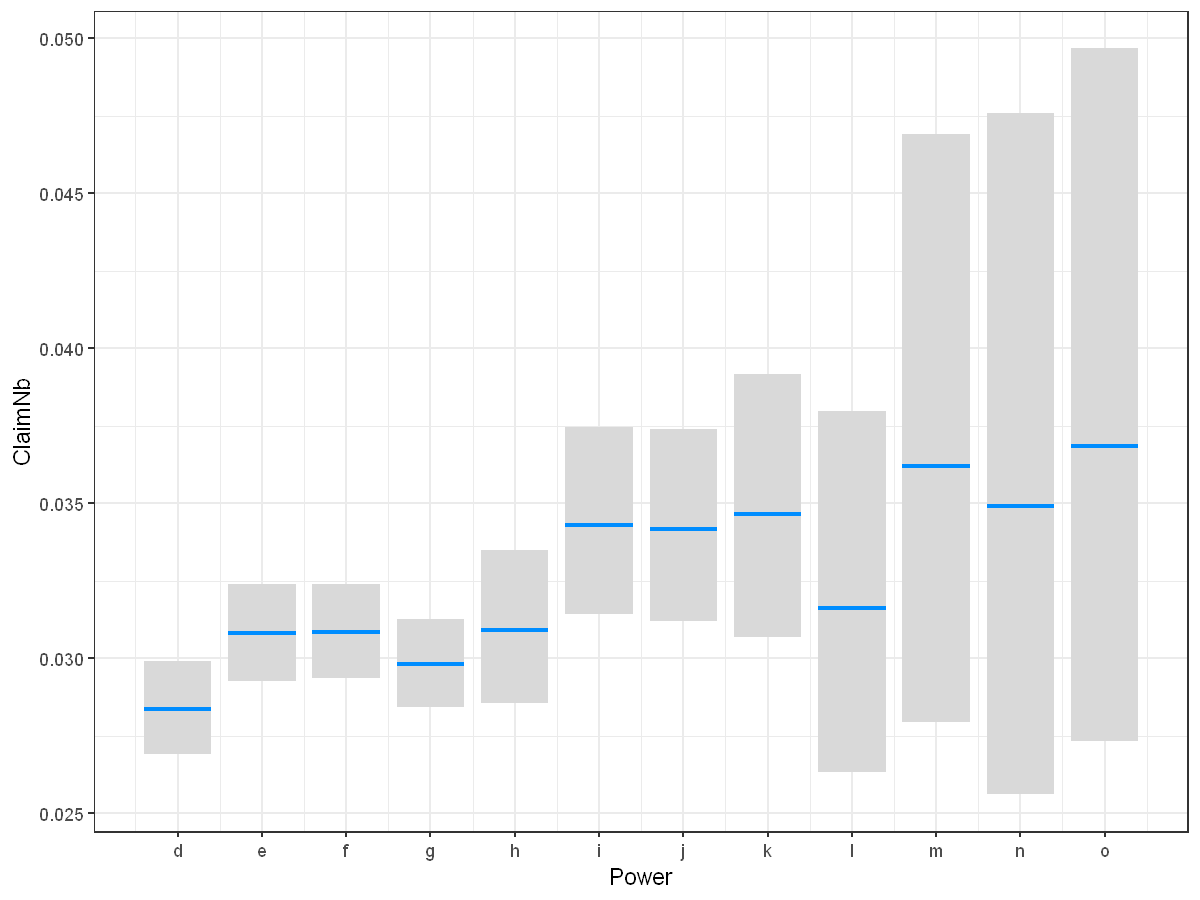

In [18]:
visreg(m1, "Power", type="conditional", scale="response", gg=TRUE, rug=FALSE, partial=FALSE) + theme_bw()

Warning message:
"You are attempting to transform a contrast.  The resulting plot is not guaranteed to be meaningful."


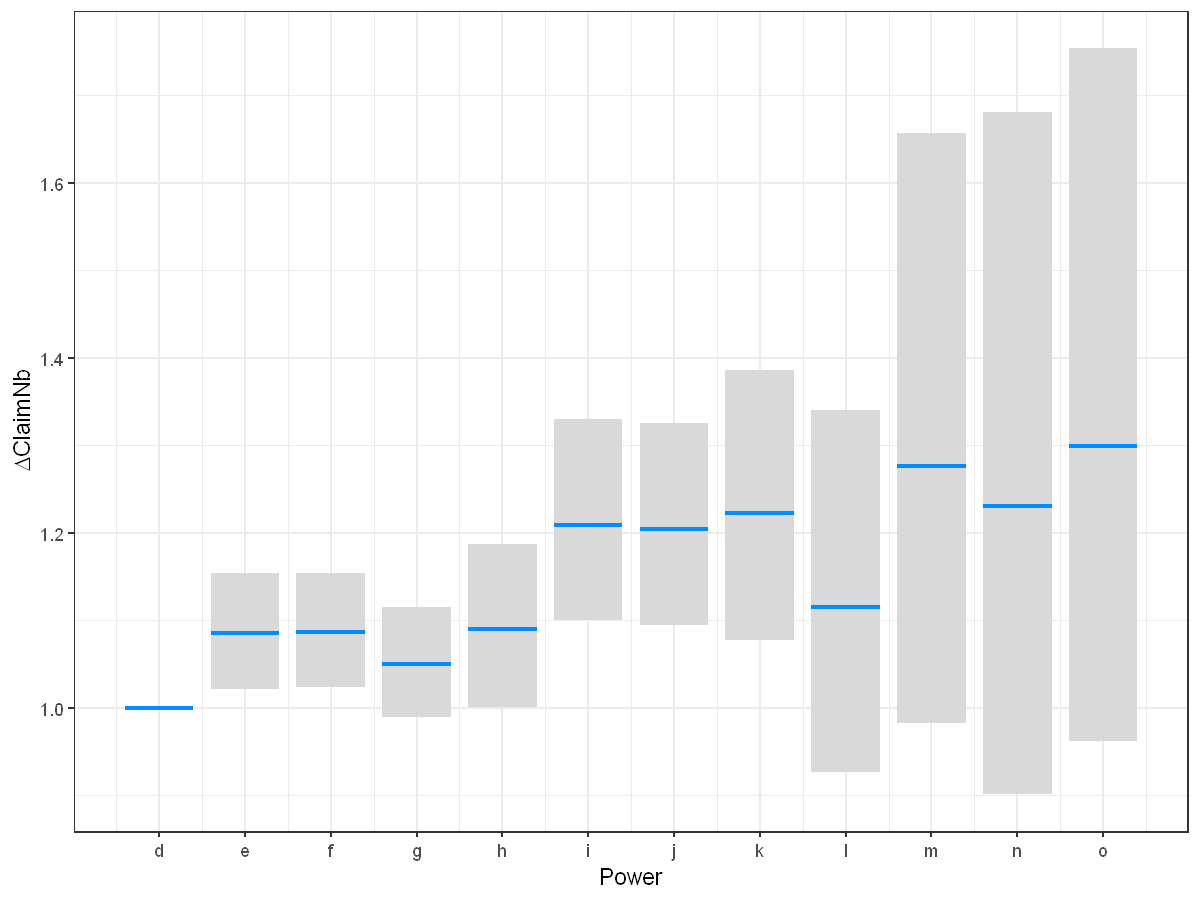

In [19]:
visreg(m1, "Power", type="contrast", scale="response", gg=TRUE, rug=FALSE, partial=FALSE) + theme_bw()

##### Gas

Warning message:
"You are attempting to transform a contrast.  The resulting plot is not guaranteed to be meaningful."


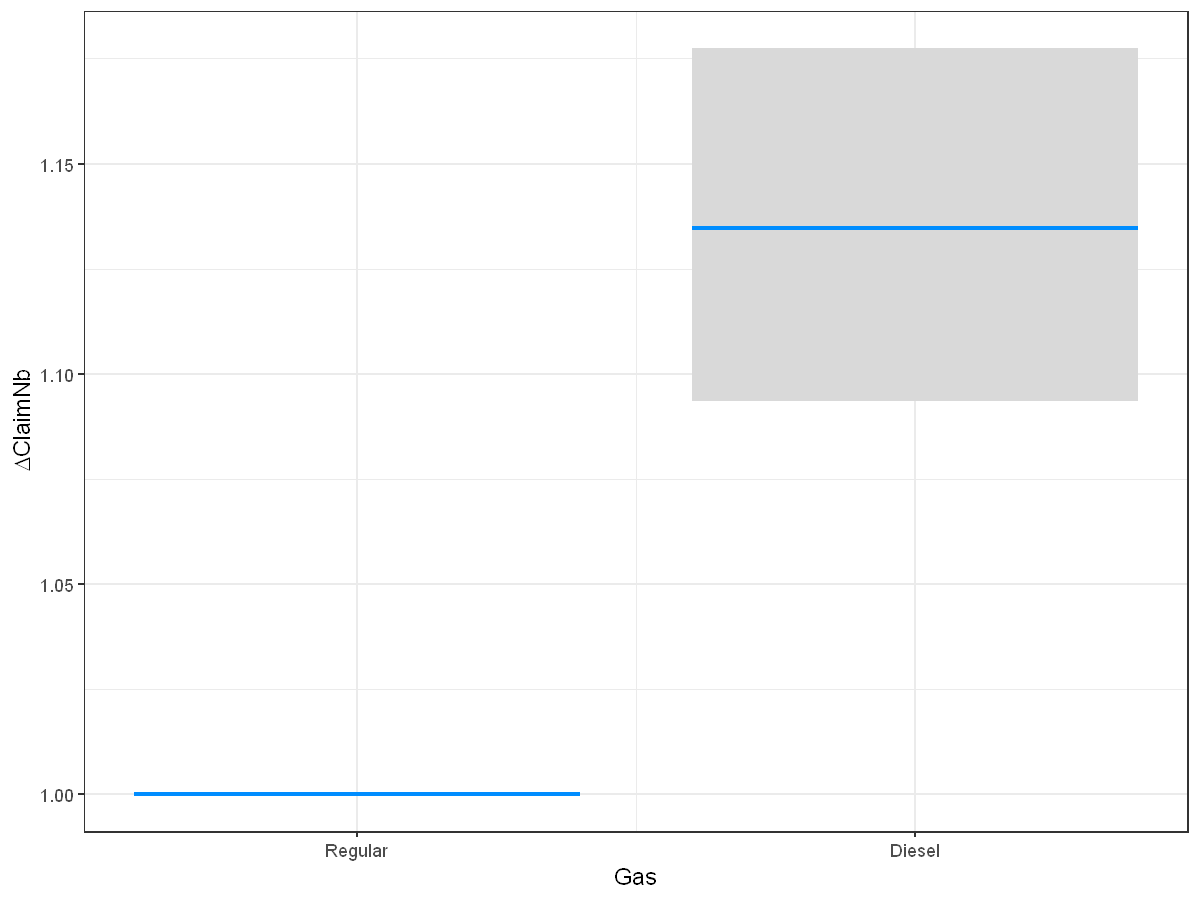

In [20]:
visreg(m1, "Gas", type="contrast", scale="response", gg=TRUE, rug=FALSE, partial=FALSE) + theme_bw()

##### Region 

Warning message:
"You are attempting to transform a contrast.  The resulting plot is not guaranteed to be meaningful."


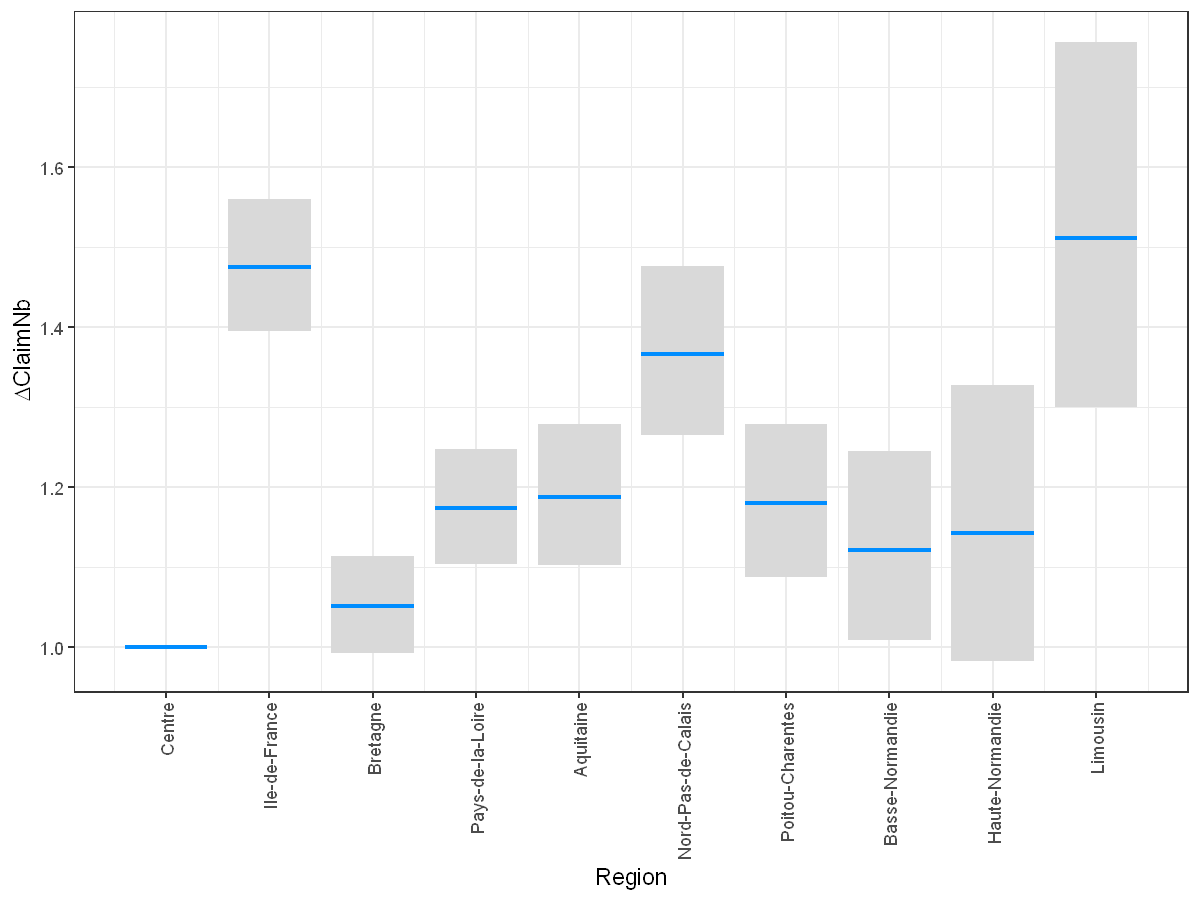

In [21]:
visreg(m1, "Region", type="contrast", scale="response", gg=TRUE, rug=FALSE, partial=FALSE) + theme_bw() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

##### Brand

Warning message:
"You are attempting to transform a contrast.  The resulting plot is not guaranteed to be meaningful."


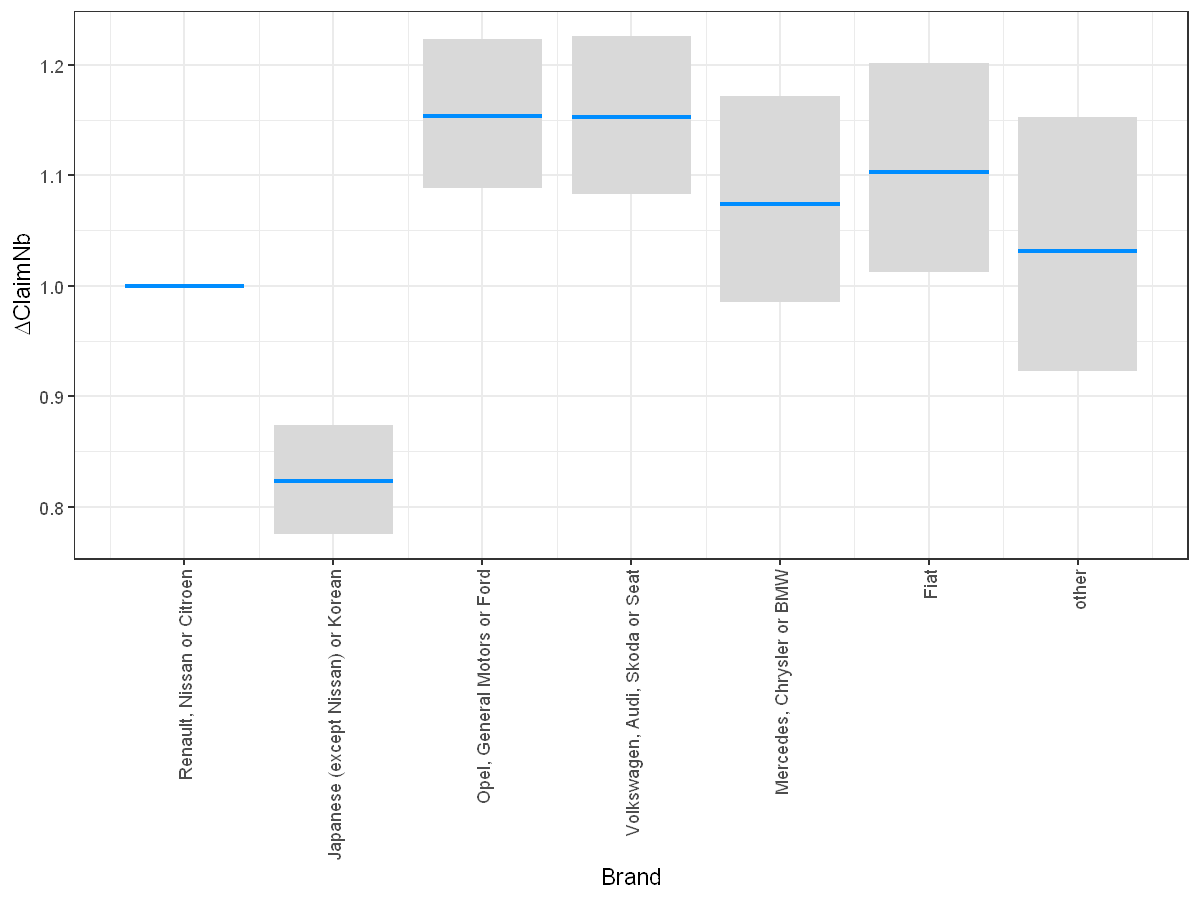

In [22]:
visreg(m1, "Brand", type="contrast", scale="response", gg=TRUE, rug=FALSE, partial=FALSE) + theme_bw() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

#### Comparing two models

We see some levels of some variables appear to be not significantly different from 0 (or 1 on the response scale). Moreover, it could be that some levels appear to be significantly different from 0, but are not significantly different from each other and could be merged.

If we wish to perform a likelihood ratio test between the full model $m_1$ and the model without any explanatory variables $m_0$

In [23]:
anova(m0, m1, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,328691,84298.99,NA,NA,NA
2,328664,83916.25,27,382.7405,1.615938e-64


Note:

Null Deviance = 2(LL(Saturated Model) - LL(Null Model)) on df = df_Sat - df_Null

Residual Deviance = 2(LL(Saturated Model) - LL(Proposed Model)) df = df_Sat - df_Proposed

##### Predict claim frequencies

If we want to predict claim frequencies, we can directly use the predict function. We need to specify that the output needs to be of *type = "response"*, so that we obtain claim frequencies, rather than the linear predictor (on the "score" scale). For example, for the first four lines of the testing_set, we get:

In [24]:
predict(m1, head(testing_set, 4), type="response")

1           8           9          14 
0.005607189 0.002614029 0.061326100 0.013401838

### Offset or weights ?

Let us compare the previous model with the following model, which, some call a "Poisson rate model")

In [25]:
m2 = glm(ClaimNb/Exposure ~ Power + Gas + Brand + Region, 
         data = training_set,
         weight = training_set$Exposure,
         family = poisson(link = log))
summary(m2)

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.142857"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.142857"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.225806"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.538462"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.898551"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 8.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.508772"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.075269"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.846154"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.030303"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 11.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.225806"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.263158"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.612903"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.515152"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 16.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x 

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.075269"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.347826"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.545455"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.449275"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.923077"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 8.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.086957"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.785714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.921569"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.166667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.136364"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.470588"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.041667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.538462"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.449275"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.204819"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.125000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.204819"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.369863"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.470588"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.564103"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.777778"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 8.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.225806"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.369863"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.882353"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.714286"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.470588"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.846154"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.369863"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 33.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.571429"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.851852"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.369863"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.702703"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.882353"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.380952"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.564103"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.176471"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.761905"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.882353"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.857143"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.785714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.555556"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.369863"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.083333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.272727"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 8.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.545455"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.777778"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.190476"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.030303"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.063830"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.166667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.204819"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.439024"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.010101"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.694915"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.882353"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.298701"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 9.090909"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.761905"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.449275"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.388889"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.515152"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.439024"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.298701"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 11.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.761905"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.531646"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.173913"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.190476"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.470588"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.030928"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.123596"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.041667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.508772"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.439024"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 16.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.702703"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 9.090909"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.703704"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.857143"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.538462"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.612903"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.555556"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.439024"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.470588"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.449275"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.562500"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.896552"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.587302"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.388889"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.785714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.587302"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.263158"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.785714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 11.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.380952"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.448276"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.380952"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.562500"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.030928"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.851852"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.449275"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.555556"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.176471"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.694915"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.639344"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.612903"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.225806"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.075269"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.315789"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.083333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.272727"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.380952"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.166667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.272727"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 11.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.564103"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.985075"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.555556"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.692308"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.564103"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 16.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.010101"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.687500"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.075269"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.063830"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.136364"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.449275"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.197802"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 9.090909"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.176471"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.882353"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.086957"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.470588"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.439024"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.389831"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.515152"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.851852"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.846154"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 9.090909"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.075269"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.587302"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.075269"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.127660"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.555556"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.941176"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.470588"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.923077"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.694915"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.315789"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.347826"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.272727"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.851852"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 16.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.857143"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.123596"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.204819"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.123596"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.173913"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.225806"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.923077"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.083333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.173913"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.263158"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.075269"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.882353"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.818182"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.571429"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.785714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.083333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.010101"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.851852"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.703704"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.639344"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.166667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.857143"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 8.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.587302"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.555556"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.142857"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.941176"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.941176"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.439024"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 9.090909"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.564103"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 9.090909"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.030928"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.219512"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.255319"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.818182"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.470588"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.123596"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.380952"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.694915"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.083333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.448276"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.562500"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.631579"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.041667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.703704"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.896552"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.754386"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.555556"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 9.090909"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.347826"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 11.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.818182"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.263158"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.263158"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 11.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.941176"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.439024"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.369863"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.785714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.631579"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.851852"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.123596"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 9.090909"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.448276"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.851852"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.347826"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.846154"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.030303"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.388889"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.298701"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.380952"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.692308"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.142857"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.761905"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.631579"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.846154"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 11

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.564103"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.562500"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.612903"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.612903"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.694915"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.754386"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.785714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.142857"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.857143"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.083333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.448276"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.405405"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.061856"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.265823"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.564103"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.123596"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.272727"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.369863"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.347826"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.272727"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.219512"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.272727"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.225806"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 33.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.166667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.162791"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.265823"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.388889"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.449275"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.127660"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.631579"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.347826"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.846154"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.020408"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.857143"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.703704"
Warning message in dpois(y, mu, log = TRUE):
"non-integer

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 8.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 11.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 8.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.777778"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.587302"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.448276"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.692308"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.347826"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.631579"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.225806"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 9.090909"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.761905"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.692308"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.571429"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.631579"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.136364"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.173913"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.030928"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.204819"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.063830"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.225806"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.448276"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.777778"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.703704"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.204819"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.166667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.639344"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.166667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.125000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.694915"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.272727"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.538462"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.219512"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 33.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.761905"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.515152"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.127660"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.127660"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.703704"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.882353"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.225806"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.941176"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.173913"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.041667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.075269"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.162791"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.127660"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.562500"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.818182"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.777778"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.857143"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.555556"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.219512"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.136364"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.444444"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.439024"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.369863"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.136364"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.041667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.785714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.265823"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.020408"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.702703"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.263158"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.142857"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.162791"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.545455"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.204819"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.449275"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.538462"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.439024"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.219512"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.515152"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.449275"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.380952"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.612903"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.882353"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.857143"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.125000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.063830"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.492537"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.272727"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.086957"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.562500"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.388889"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 15.384615"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.612903"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.702703"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.754386"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.448276"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.818182"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.265823"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.136364"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.136364"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.703704"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.166667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.612903"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.564103"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.754386"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.388889"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.739726"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.389831"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.063830"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.149425"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.219512"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.030928"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.538462"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.083333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.846154"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.515152"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.515152"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 9.090909"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.086957"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.173913"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.204819"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.692308"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.564103"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.470588"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.703704"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.754386"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.761905"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 8.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.587302"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.380952"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.075269"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.851852"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.692308"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.562500"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.219512"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 14.285714"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.538462"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.941176"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 12.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.052632"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.282051"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.777778"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.538462"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 11.111111"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.612903"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.702703"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4.545455"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.125000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.030928"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.587302"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.298701"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.818182"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.325581"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.857143"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.960784"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.086957"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.162791"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.562500"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.388889"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.263158"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 7.142857"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.777778"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.174603"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.587302"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.125000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.127660"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.773585"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.886792"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.448276"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.380952"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.369863"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.703704"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.448276"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.408451"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 6.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.515152"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.030303"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.857143"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.040816"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.739726"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.428571"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.176471"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.098901"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.162791"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.380952"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.250000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.587302"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.265823"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.409639"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.234568"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.724138"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.351351"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 33.333333"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.777778"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.631579"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.448276"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.222222"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.818182"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.500000"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3

Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.173913"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.777778"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 2.777778"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.923077"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.470588"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.515152"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.587302"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.666667"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 28.571429"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.754386"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 5.555556"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 3.773585"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 1.923077"
Warning message in dpois(y, mu, log = TRUE):
"non-integer x = 4


Call:
glm(formula = ClaimNb/Exposure ~ Power + Gas + Brand + Region, 
    family = poisson(link = log), data = training_set, weights = training_set$Exposure)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5085  -0.3498  -0.2662  -0.1481   6.6335  

Coefficients:
                                        Estimate Std. Error  z value Pr(>|z|)
(Intercept)                             -2.92738    0.02686 -108.978  < 2e-16
Powere                                   0.08199    0.03121    2.627 0.008623
Powerf                                   0.08333    0.03058    2.725 0.006431
Powerg                                   0.04901    0.03044    1.610 0.107361
Powerh                                   0.08583    0.04350    1.973 0.048480
Poweri                                   0.18977    0.04842    3.920 8.87e-05
Powerj                                   0.18583    0.04873    3.814 0.000137
Powerk                                   0.20036    0.06432    3.115 0.001839
Powerl    

Let us compare the coefficients

In [26]:
cbind(m1$coef, m2$coef)

(Intercept),-2.92738024,-2.92738024
Powere,0.08198571,0.08198571
Powerf,0.08333279,0.08333279
Powerg,0.04900718,0.04900718
Powerh,0.08583395,0.08583395
Poweri,0.18976716,0.18976716
Powerj,0.18583253,0.18583253
Powerk,0.20036184,0.20036184
Powerl,0.10846684,0.10846685
Powerm,0.24356215,0.24356215
Powern,0.20713451,0.20713452


Why does that work ? See whiteboard or : https://stats.stackexchange.com/a/270151

### Remarks 

Up to now, we have 
1. Load the original dataset. 
2. We have prepared the data in some way (relevel the factors we instance). We could have binned the continuous variables.
3. Run a model on these variables.
4. Predict for some new observations (-> testing set ?).


There are some flaws in the way of working. 

- We should not prepare the data *before* splitting into training and testing set. Although, we did not include information from the testing set into the training set here, we could have done so, if, for example, we were to standardize some variables. Indeed, if we standardize a continuous variable by substracting the mean and dividing by the standard deviation, since we have computed the mean and the standard deviation on the whole dataset (rather than only on the training set), we include information about the testing_set into the training_set and the otherway around as well.

- What if new data comes ? How will we handle this ? Do we need to reprocess the data preparation again ? How do we keep track of all the preprocessing that we have done ?

One way to handle this issues correctly is working with **recipes** (https://recipes.tidymodels.org/index.html). So, let's restart this session and use **recipes**.

We will reload the data from the parquet files and directly split the data into a training and a testing set.

## Restart with recipes

In [27]:
dataset = read_parquet(file = "../data/dataset.parquet")

set.seed(21)
in_training = createDataPartition(dataset$ClaimNb, times = 1, p = 0.8, list = FALSE)
training_set = dataset[in_training, ]
testing_set = dataset[-in_training, ]

We can specify a *recipe* to prepare the data correctly. The idea is to define this once, and apply it on different datasets, so we don't need to preprocess the data manually.

In [28]:
rec_0 <- recipe(ClaimNb ~ Exposure + Power + Gas + Brand + Region, data = training_set) %>%
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    prep()
rec_0



-- Recipe ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



-- Inputs 

Number of variables by role

outcome:   1
predictor: 5



-- Training information 

Training data contained 328692 data points and no incomplete rows.



-- Operations 

* Re-order factor level to ref_level for: Power | Trained

* Re-order factor level to ref_level for: Gas | Trained

* Re-order factor level to ref_level for: Region | Trained

* Re-order factor level to ref_level for: Brand | Trained



In [29]:
output = bake(rec_0, new_data = head(training_set, 4))
output

Exposure,Power,Gas,Brand,Region,ClaimNb
<dbl>,<fct>,<fct>,<fct>,<fct>,<int>
0.84,g,Diesel,Japanese (except Nissan) or Korean,Aquitaine,0
0.52,f,Regular,Japanese (except Nissan) or Korean,Nord-Pas-de-Calais,0
0.45,f,Regular,Japanese (except Nissan) or Korean,Nord-Pas-de-Calais,0
0.15,g,Diesel,Japanese (except Nissan) or Korean,Pays-de-la-Loire,0


Let us check the reference levels of the output

In [30]:
str(output)

tibble [4 x 6] (S3: tbl_df/tbl/data.frame)
 $ Exposure: num [1:4] 0.84 0.52 0.45 0.15
 $ Power   : Factor w/ 12 levels "d","e","f","g",..: 4 3 3 4
 $ Gas     : Factor w/ 2 levels "Regular","Diesel": 2 1 1 2
 $ Brand   : Factor w/ 7 levels "Renault, Nissan or Citroen",..: 3 3 3 3
 $ Region  : Factor w/ 10 levels "Centre","Aquitaine",..: 2 8 8 9
 $ ClaimNb : int [1:4] 0 0 0 0


to be compared with 

In [31]:
str(training_set)

'data.frame':	328692 obs. of  10 variables:
 $ PolicyID : Factor w/ 413169 levels "1","2","3","4",..: 2 3 4 5 6 7 10 11 12 13 ...
 $ ClaimNb  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Exposure : num  0.84 0.52 0.45 0.15 0.75 0.81 0.34 0.1 0.77 0.55 ...
 $ Power    : Factor w/ 12 levels "d","e","f","g",..: 4 3 3 4 4 1 6 3 3 2 ...
 $ CarAge   : int  0 2 2 0 0 1 0 2 2 0 ...
 $ DriverAge: int  46 38 38 41 41 27 44 32 32 33 ...
 $ Brand    : Factor w/ 7 levels "Fiat","Japanese (except Nissan) or Korean",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Gas      : Factor w/ 2 levels "Diesel","Regular": 1 2 2 1 1 2 2 1 1 2 ...
 $ Region   : Factor w/ 10 levels "Aquitaine","Basse-Normandie",..: 1 8 8 9 9 1 6 4 4 6 ...
 $ Density  : int  76 3003 3003 60 60 695 27000 23 23 1746 ...


We can use the recipe on the training and the testing set, and construct the same GLM as above. We can check that the results are the same and that we can predict on the testing set

In [32]:
train_baked = bake(rec_0, new_data = training_set)
test_baked = bake(rec_0, new_data = testing_set) 

m3 = glm(ClaimNb ~ offset(log(Exposure)) + Power + Gas + Brand + Region, data = train_baked, family = poisson())
summary(m3)


Call:
glm(formula = ClaimNb ~ offset(log(Exposure)) + Power + Gas + 
    Brand + Region, family = poisson(), data = train_baked)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5085  -0.3498  -0.2662  -0.1481   6.6335  

Coefficients:
                                        Estimate Std. Error  z value Pr(>|z|)
(Intercept)                             -2.92738    0.02686 -108.980  < 2e-16
Powere                                   0.08199    0.03121    2.627 0.008622
Powerf                                   0.08333    0.03058    2.725 0.006430
Powerg                                   0.04901    0.03044    1.610 0.107353
Powerh                                   0.08583    0.04350    1.973 0.048475
Poweri                                   0.18977    0.04841    3.920 8.87e-05
Powerj                                   0.18583    0.04873    3.814 0.000137
Powerk                                   0.20036    0.06432    3.115 0.001839
Powerl                                 

In [33]:
coefs_m1 = as.data.frame(m1$coef) %>% tibble::rownames_to_column()
coefs_m3 = as.data.frame(m3$coef) %>% tibble::rownames_to_column()

coefs_m1 %>% left_join(coefs_m3)

Joining with `by = join_by(rowname)`


rowname,m1$coef,m3$coef
<chr>,<dbl>,<dbl>
(Intercept),-2.92738024,-2.92738024
Powere,0.08198571,0.08198571
Powerf,0.08333279,0.08333279
Powerg,0.04900718,0.04900718
Powerh,0.08583395,0.08583395
Poweri,0.18976716,0.18976716
Powerj,0.18583253,0.18583253
Powerk,0.20036184,0.20036184
Powerl,0.10846684,0.10846684


In [34]:
predict(m3, head(test_baked), type="response")

1           2           3           4           5           6 
0.005607189 0.002614029 0.061326100 0.013401838 0.009427595 0.055560893

**But,** we still need to bake the testing set before calling the predict function. **What if we don't want to call this bake function anymore ?**

## Use Workflows and parsnip to specify model

We can define a workflow that first prepares the data and the goes into the model to either fit or predict.

A list of models that work with parsnip is provided here: https://www.tidymodels.org/find/parsnip/

In [35]:
# Copy paste from above:
rec_4 <- recipe(ClaimNb ~ Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    prep()

In [36]:
bake(rec_4, head(training_set, 4))

Power,Gas,Region,Brand,Exposure,ClaimNb
<fct>,<fct>,<fct>,<fct>,<dbl>,<int>
g,Diesel,Aquitaine,Japanese (except Nissan) or Korean,0.84,0
f,Regular,Nord-Pas-de-Calais,Japanese (except Nissan) or Korean,0.52,0
f,Regular,Nord-Pas-de-Calais,Japanese (except Nissan) or Korean,0.45,0
g,Diesel,Pays-de-la-Loire,Japanese (except Nissan) or Korean,0.15,0


Along with the *workflows* package, we can define a whole .. workflow. This will only define the workflow. No fit is done at this point

In [37]:
m4_mod = poisson_reg() %>%
  set_engine("glm")

m4_wflow <- 
  workflow() %>% 
  add_recipe(rec_4) %>%
  add_model(m4_mod, formula = ClaimNb ~ Power + Gas + Region + Brand + offset(log(Exposure))) # Formula of the model
  
m4_wflow

== Workflow ==================================================================================================================================================================================
Preprocessor: Recipe
Model: poisson_reg()

-- Preprocessor ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
4 Recipe Steps

* step_relevel()
* step_relevel()
* step_relevel()
* step_relevel()

-- Model -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Poisson Regression Model Specification (regression)

Computational engine: glm 


We can fit, using the function fit.

The fit will consist in "baking" the data using the provided recipe, and estimate the coefficients of the GLM

In [38]:
m4_fit <- fit(m4_wflow, data = training_set)

In [39]:
# extract_fit_engine(m4_fit) is the GLM object
# We can call the summary function on it
summary(extract_fit_engine(m4_fit))


Call:
stats::glm(formula = ClaimNb ~ Power + Gas + Region + Brand + 
    offset(log(Exposure)), family = stats::poisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5085  -0.3498  -0.2662  -0.1481   6.6335  

Coefficients:
                                        Estimate Std. Error  z value Pr(>|z|)
(Intercept)                             -2.92738    0.02686 -108.980  < 2e-16
Powere                                   0.08199    0.03121    2.627 0.008622
Powerf                                   0.08333    0.03058    2.725 0.006430
Powerg                                   0.04901    0.03044    1.610 0.107353
Powerh                                   0.08583    0.04350    1.973 0.048475
Poweri                                   0.18977    0.04841    3.920 8.87e-05
Powerj                                   0.18583    0.04873    3.814 0.000137
Powerk                                   0.20036    0.06432    3.115 0.001839
Powerl                            

What if we want to predict claim frequencies from the testing set ?

In [40]:
predict(m4_fit, head(testing_set, 4))

.pred
<dbl>
0.005607189
0.002614029
0.061326100
0.013401838


Do the predictions match what we've done before ?

In [41]:
max(abs(predict(m4_fit, testing_set) - predict(m1, testing_set, type="response")))

[1] 8.326673e-17

What if the new data comes in as a text file ? Do we need to specify what variables are factors ?

In [42]:
new_data = data.frame(
    "Exposure" = 0.8,
    "Power" = 'f',
    "Brand" = "other",
    "Gas" = "Regular",
    "Region" = "Centre"
    )

predict(m4_fit, new_data)

.pred
<dbl>
0.0480101


## Build Model with all features 

Now that we have understood how to build GLM models with workflows and recipes, we can use all the variables from the dataset. We will use our learnings from the session on GBM to include some interaction terms.

In [43]:
rec_5 <- recipe(ClaimNb ~ Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    prep()

m5_mod = poisson_reg() %>%
  set_engine("glm") 

m5_wflow <- 
  workflow() %>% 
  add_model(m5_mod, formula = ClaimNb ~ offset(log(Exposure)) + 
                                        Power + 
                                        Gas + 
                                        Region + 
                                        Brand + 
                                        Gas * Power + 
                                        Gas * Region) %>% # Formula of the model
  add_recipe(rec_5)
m5_fit = m5_wflow %>% fit(training_set)

In [44]:
summary(extract_fit_engine(m5_fit))


Call:
stats::glm(formula = ClaimNb ~ offset(log(Exposure)) + Power + 
    Gas + Region + Brand + Gas * Power + Gas * Region, family = stats::poisson, 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5031  -0.3475  -0.2661  -0.1475   6.6192  

Coefficients:
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -2.925703   0.031537 -92.769  < 2e-16
Powere                                   0.033507   0.040333   0.831 0.406109
Powerf                                   0.012188   0.043242   0.282 0.778054
Powerg                                   0.118517   0.037132   3.192 0.001414
Powerh                                   0.179694   0.068533   2.622 0.008741
Poweri                                   0.230044   0.055140   4.172 3.02e-05
Powerj                                   0.276424   0.064733   4.270 1.95e-05
Powerk                                   0.226365   0.085561   2.646 0.008153


### Cross-validation
We will use cross-validation to find the relevant features to keep and how to bin the variables.

In [45]:
folds = training_set %>% vfold_cv(strata = ClaimNb, v = 5)

In [46]:
res = fit_resamples(m5_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))

In [48]:
collect_metrics(res)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.1658012,5,0.001471508,Preprocessor1_Model1


### Without interactions



In [50]:
rec_6 <- recipe(ClaimNb ~ Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    prep()

m6_mod = poisson_reg() %>%
  set_engine("glm") 

m6_wflow <- 
  workflow() %>% 
  add_model(m6_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec_6)
m6_fit = m6_wflow %>% 
    fit(training_set)

In [51]:
res = fit_resamples(m6_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))

collect_metrics(res)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.1657952,5,0.001507069,Preprocessor1_Model1


We will not keep the interaction for now..

We can try to merge some of the levels that appear to be not significantly different.

### Group some Brands

In [52]:
rec_7 <- recipe(ClaimNb ~ Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    prep()

m7_mod = poisson_reg() %>%
  set_engine("glm") 

m7_wflow <- 
  workflow() %>% 
  add_model(m7_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec_7)

res7 = fit_resamples(m7_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))
collect_metrics(res7)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.165793,5,0.001504152,Preprocessor1_Model1


In [54]:
m7_fit = m7_wflow %>% 
    fit(training_set)
summary(extract_fit_engine(m7_fit))


Call:
stats::glm(formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure, 
    family = stats::poisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5093  -0.3506  -0.2662  -0.1480   6.6305  

Coefficients:
                                        Estimate Std. Error  z value Pr(>|z|)
(Intercept)                             -2.92698    0.02673 -109.511  < 2e-16
Powere                                   0.08818    0.03101    2.843 0.004465
Powerf                                   0.08505    0.03050    2.789 0.005293
Powerg                                   0.04737    0.03029    1.564 0.117856
Powerh                                   0.07704    0.04330    1.779 0.075194
Poweri                                   0.17928    0.04796    3.738 0.000186
Powerj                                   0.17717    0.04832    3.666 0.000246
Powerk                                   0.18850    0.06378    2.956 0.003121
Powerl                                   0.08957  

### Group some levels of Power

For example, one could regroup levels e-f-g-h of variable power.

In [55]:
rec_8 <- recipe(ClaimNb ~ Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, "e-f-g-h" = c("e", "f", "g", "h"))) %>%
    prep()

m8_mod = poisson_reg() %>%
  set_engine("glm") 

m8_wflow <- 
  workflow() %>% 
  add_model(m8_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec_8)

res8 = fit_resamples(m8_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))
collect_metrics(res8)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.1657868,5,0.001504608,Preprocessor1_Model1


In [56]:
m8_fit = m8_wflow %>% 
    fit(training_set)
summary(extract_fit_engine(m8_fit))


Call:
stats::glm(formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure, 
    family = stats::poisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5104  -0.3492  -0.2664  -0.1482   6.6317  

Coefficients:
                                        Estimate Std. Error  z value Pr(>|z|)
(Intercept)                             -2.92788    0.02670 -109.661  < 2e-16
Powere-f-g-h                             0.07249    0.02622    2.765 0.005700
Poweri                                   0.17905    0.04796    3.733 0.000189
Powerj                                   0.17635    0.04831    3.651 0.000262
Powerk                                   0.18774    0.06377    2.944 0.003239
Powerl                                   0.08816    0.09276    0.950 0.341908
Powerm                                   0.20891    0.13060    1.600 0.109675
Powern                                   0.18587    0.15817    1.175 0.239950
Powero                                   0.25478  

Let us try a different regrouping:

In [57]:
rec_8 <- recipe(ClaimNb ~ Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, "d-e" = c("d", "e"), "f-g-h" = c("f", "g", "h"))) %>%
    prep()

m8_mod = poisson_reg() %>%
  set_engine("glm") 

m8_wflow <- 
  workflow() %>% 
  add_model(m8_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec_8)

res8 = fit_resamples(m8_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))
collect_metrics(res8)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.1657962,5,0.001508757,Preprocessor1_Model1


But it cross-validation error increases.
Finally, let us regroup the some other levels

In [58]:
rec_9 <- recipe(ClaimNb ~ Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW",
                                                           "Opel, General Motors or Ford",
                                                           "other", 
                                                           "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, 
                                                 "e-f-g-h" = c("e", "f", "g", "h"),
                                                 "i-j-k-l-m" = c("i", "j", "k", "l", "m"),
                                                 "n-o" = c("n", "o")
                                             )) %>%
    prep()

m9_mod = poisson_reg() %>%
  set_engine("glm") 

m9_wflow <- 
  workflow() %>% 
  add_model(m9_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec_9)

res9 = fit_resamples(m9_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))
collect_metrics(res9)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.1657731,5,0.001506944,Preprocessor1_Model1


In [59]:
m9_fit = m9_wflow %>% 
    fit(training_set)
summary(extract_fit_engine(m9_fit))


Call:
stats::glm(formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure, 
    family = stats::poisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5016  -0.3494  -0.2663  -0.1483   6.6322  

Coefficients:
                                        Estimate Std. Error  z value Pr(>|z|)
(Intercept)                             -2.92713    0.02667 -109.742  < 2e-16
Powere-f-g-h                             0.07292    0.02621    2.782  0.00541
Poweri-j-k-l-m                           0.17380    0.03441    5.051 4.40e-07
Powern-o                                 0.22131    0.11122    1.990  0.04661
GasDiesel                                0.12740    0.01839    6.929 4.22e-12
RegionAquitaine                          0.17239    0.03793    4.545 5.50e-06
RegionBasse-Normandie                    0.11241    0.05388    2.086  0.03694
RegionBretagne                           0.05029    0.02952    1.703  0.08850
RegionHaute-Normandie                    0.13038  

In [61]:
rec <- recipe(ClaimNb ~ Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, 
                                                 "e-f-g-h" = c("e", "f", "g", "h"),
                                                 "i-j-k-l-m" = c("i", "j", "k", "l", "m"),
                                                 "n-o" = c("n", "o")
                                                )) %>%
    step_mutate(Region = forcats::fct_collapse(Region, 
                                                 "A" = c("Pays-de-la-Loire", "Poitou-Charentes", "Aquitaine")
                                                )) %>%
    prep()

m_mod = poisson_reg() %>%
  set_engine("glm") 

m10_wflow <- 
  workflow() %>% 
  add_model(m_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec)

res10 = fit_resamples(m10_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))
collect_metrics(res10)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.16576,5,0.001511283,Preprocessor1_Model1


## Consider the continuous variables 

Let us first add the variables without any preprocessing.

In [62]:
rec <- recipe(ClaimNb ~ DriverAge + CarAge + Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, 
                                                 "e-f-g-h" = c("e", "f", "g", "h"),
                                                 "i-j-k-l-m" = c("i", "j", "k", "l", "m"),
                                                 "n-o" = c("n", "o")
                                                )) %>%
    step_mutate(Region = forcats::fct_collapse(Region, 
                                                 "A" = c("Pays-de-la-Loire", "Poitou-Charentes", "Aquitaine")
                                                )) %>%
    prep()

m_mod = poisson_reg() %>%
  set_engine("glm") 

m10_wflow <- 
  workflow() %>% 
  add_model(m_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec)

res10 = fit_resamples(m10_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))
collect_metrics(res10)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.1653386,5,0.001515015,Preprocessor1_Model1


In [63]:
m10_fit = m10_wflow %>% 
    fit(training_set)
summary(extract_fit_engine(m10_fit))


Call:
stats::glm(formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure, 
    family = stats::poisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5364  -0.3453  -0.2681  -0.1500   6.5327  

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -2.3259147  0.0449218 -51.777  < 2e-16
DriverAge                               -0.0098563  0.0006363 -15.489  < 2e-16
CarAge                                  -0.0122924  0.0018583  -6.615 3.72e-11
Powere-f-g-h                             0.0752926  0.0262274   2.871  0.00409
Poweri-j-k-l-m                           0.1930871  0.0343932   5.614 1.98e-08
Powern-o                                 0.2358311  0.1112179   2.120  0.03397
GasDiesel                                0.0836724  0.0186591   4.484 7.32e-06
RegionA                                  0.1488080  0.0238067   6.251 4.09e-10
RegionBasse-Normandie                    

One possibility is to add polynomial terms. We then need to find the optimal degree of the polynomial. For example, let us consider a polynomial for DriverAge and a polynomial for CarAge

In [64]:
rec <- recipe(ClaimNb ~ DriverAge + CarAge + Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, 
                                                 "e-f-g-h" = c("e", "f", "g", "h"),
                                                 "i-j-k-l-m" = c("i", "j", "k", "l", "m"),
                                                 "n-o" = c("n", "o")
                                                )) %>%
    step_mutate(Region = forcats::fct_collapse(Region, 
                                                 "A" = c("Pays-de-la-Loire", "Poitou-Charentes", "Aquitaine")
                                                )) %>%
    step_poly(DriverAge, degree=2) %>%
    step_poly(CarAge, degree=2) %>%
    prep()

m_mod = poisson_reg() %>%
  set_engine("glm") 

m11_wflow <- 
  workflow() %>% 
  add_model(m_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec)

res11 = fit_resamples(m11_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))
collect_metrics(res11)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.165064,5,0.001485699,Preprocessor1_Model1


We can change the degree. After several trial and error we can find...

In [66]:
rec <- recipe(ClaimNb ~ DriverAge + CarAge + Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, 
                                                 "e-f-g-h" = c("e", "f", "g", "h"),
                                                 "i-j-k-l-m" = c("i", "j", "k", "l", "m"),
                                                 "n-o" = c("n", "o")
                                                )) %>%
    step_mutate(Region = forcats::fct_collapse(Region, 
                                                 "A" = c("Pays-de-la-Loire", "Poitou-Charentes", "Aquitaine")
                                                )) %>%
    step_poly(DriverAge, degree=7) %>%
    step_poly(CarAge, degree=2) %>%
    prep()

m_mod = poisson_reg() %>%
  set_engine("glm") 

m11_wflow <- 
  workflow() %>% 
  add_model(m_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec)

res11 = fit_resamples(m11_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))
collect_metrics(res11)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.1644538,5,0.001451156,Preprocessor1_Model1


In [68]:
m11_fit = m11_wflow %>% 
    fit(training_set)
summary(extract_fit_engine(m11_fit))


Call:
stats::glm(formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure, 
    family = stats::poisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8909  -0.3419  -0.2650  -0.1484   6.6824  

Coefficients:
                                         Estimate Std. Error  z value Pr(>|z|)
(Intercept)                              -2.93816    0.02757 -106.583  < 2e-16
Powere-f-g-h                              0.09047    0.02627    3.444 0.000572
Poweri-j-k-l-m                            0.23014    0.03453    6.665 2.65e-11
Powern-o                                  0.29075    0.11128    2.613 0.008982
GasDiesel                                 0.11582    0.01877    6.170 6.81e-10
RegionA                                   0.16658    0.02382    6.993 2.69e-12
RegionBasse-Normandie                     0.08869    0.05391    1.645 0.099968
RegionBretagne                            0.05251    0.02959    1.774 0.075986
RegionHaute-Normandie                    

Another possibility was to bin the continuous variables. For example, here on DriverAge.

In [84]:
rec <- recipe(ClaimNb ~ DriverAge + CarAge + Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, 
                                                 "e-f-g-h" = c("e", "f", "g", "h"),
                                                 "i-j-k-l-m" = c("i", "j", "k", "l", "m"),
                                                 "n-o" = c("n", "o")
                                                )) %>%
    step_mutate(Region = forcats::fct_collapse(Region, 
                                                 "A" = c("Pays-de-la-Loire", "Poitou-Charentes", "Aquitaine")
                                                )) %>%
    step_discretize(DriverAge, num_breaks=25, min_unique = 2) %>%
    step_poly(CarAge, degree=2) %>%
    prep()

m_mod = poisson_reg() %>%
  set_engine("glm") 

m12_wflow <- 
  workflow() %>% 
  add_model(m_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec)

res12 = fit_resamples(m12_wflow,
                    resamples = folds,
                    metrics = metric_set(poisson_log_loss))
collect_metrics(res12)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
poisson_log_loss,standard,0.1646437,5,0.001481108,Preprocessor1_Model1


In [85]:
m12_fit = m12_wflow %>% 
    fit(training_set)
summary(extract_fit_engine(m12_fit))


Call:
stats::glm(formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure, 
    family = stats::poisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7176  -0.3418  -0.2650  -0.1485   6.6835  

Coefficients:
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                              -2.11868    0.03922 -54.018  < 2e-16
DriverAgebin02                           -0.58177    0.05028 -11.570  < 2e-16
DriverAgebin03                           -0.70481    0.05374 -13.115  < 2e-16
DriverAgebin04                           -0.84240    0.06912 -12.188  < 2e-16
DriverAgebin05                           -0.86425    0.05288 -16.345  < 2e-16
DriverAgebin06                           -0.91318    0.05279 -17.298  < 2e-16
DriverAgebin07                           -0.85164    0.06605 -12.895  < 2e-16
DriverAgebin08                           -0.93888    0.05247 -17.894  < 2e-16
DriverAgebin09                           -0.99082 

## Comparison with other models

We can compare with the previous models from the previous sessions. Note that we have NOT used the variable Density here.
Let us use our best model.

In [87]:
rec <- recipe(ClaimNb ~ DriverAge + CarAge + Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, 
                                                 "e-f-g-h" = c("e", "f", "g", "h"),
                                                 "i-j-k-l-m" = c("i", "j", "k", "l", "m"),
                                                 "n-o" = c("n", "o")
                                                )) %>%
    step_mutate(Region = forcats::fct_collapse(Region, 
                                                 "A" = c("Pays-de-la-Loire", "Poitou-Charentes", "Aquitaine")
                                                )) %>%
    step_poly(DriverAge, degree=7) %>%
    step_poly(CarAge, degree=2) %>%
    prep()

m_mod = poisson_reg() %>%
  set_engine("glm") 

m11_wflow <- 
  workflow() %>% 
  add_model(m_mod, formula = ClaimNb ~ offset(log(Exposure)) + . - Exposure) %>% # Formula of the model
  add_recipe(rec)

m11_fit = m11_wflow %>% 
    fit(training_set)

predt = predict(m11_fit, testing_set)

In [93]:
2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb,
    log = TRUE)) - sum(dpois(x = testing_set$ClaimNb, lambda = pull(predt, ".pred"), log = TRUE)))

[1] 20529.66

As expected, we are far off compared to the GBM (due to the model itself and the missing variable Density).

# Useful links

- https://raw.githubusercontent.com/rstudio/cheatsheets/main/factors.pdf
- https://www.tidymodels.org/index.html
- https://parsnip.tidymodels.org/
- https://recipes.tidymodels.org/index.html